# Contrôle optimal d'une pandémie par apprentissage par renforcement 

**Modèle SEIRD** — Algorithmes Q-Learning, SARSA et DP approchée pour le contrôle de $(S, E, I)$.

L'environnement (`model.py`) simule la dynamique SEIRD complète, mais l'agent observe uniquement $(S, E, I)$ discrétisé en bins non-uniformes. Comme démontré dans le rapport, $R$ et $D$ n'influencent pas la dynamique.

**Contrôles :** 25 actions discrètes ($5 \times 5$ grille confinement × vaccination).

**Structure du code :**
- `model.py` — Environnement Gymnasium (SEIREnv)
- `utils.py` — Discrétisation et enregistrement d'épisodes
- `algorithms.py` — Agents Q-Learning et SARSA ([pattern Gymnasium](https://gymnasium.farama.org/introduction/train_agent/))
- `heuristics.py` — Politiques de référence
- `plotting.py` — Visualisation des résultats

In [51]:
%reload_ext autoreload
%autoreload 2

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from model import SEIREnv, ProblemConfig, SocioEconomicConfig
from utils import default_bin_dicts, state_to_id, bin_center, problem_sizes, record_episode
from algorithms import QLearningAgent, SarsaAgent
from dynamic_programming import run_approximate_dp
from heuristics import policy_no_control, policy_vacc_max, policy_seuil_conf, policy_double_seuil
from plotting import (
    plot_learning_curves, plot_seird_evolution, plot_commands,
    plot_epidemic_comparison, plot_cost_decomposition, plot_sensitivity,
)

plt.rcParams.update({"figure.figsize": (14, 5), "axes.grid": True, "font.size": 11})

config = ProblemConfig()
print(f"β={config.beta}, σ={config.sigma}, γ={config.gamma}, μ={config.mu}")
print(f"R₀ = β/γ = {config.beta / config.gamma:.2f}")
print(f"Horizon = {config.max_steps} jours")

c = config.socio_eco_config
print(f"\nCoûts : C_eco={c.confinement_eco_cost}, C_vacc={c.vaccination_eco_cost}, "
      f"C_vie={c.life_cost}, C_hosp={c.infection_cost}")


β=0.27, σ=0.14, γ=0.1, μ=0.01
R₀ = β/γ = 2.70
Horizon = 365 jours

Coûts : C_eco=1.0, C_vacc=0.02, C_vie=1000.0, C_hosp=20


## 1. Discrétisation de l'espace d'états et d'actions

**État réduit :** $(S, E, I)$ uniquement — les équations de transition ne dépendent ni de $R$ ni de $D$.

**Bins non-uniformes :** Plus fins près de 0 pour $E$ et $I$ (transitions critiques).
- $S$ : 11 bins — $[0, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.97, 0.985, 1.00]$
- $E, I$ : 11 bins — $[0, 10^{-5}, 3{\times}10^{-5}, 10^{-4}, \ldots, 0.3, 1.00]$

→ $11^3 = 1331$ états × 25 actions.

In [53]:
bin_dicts = default_bin_dicts()
n_states, n_actions = problem_sizes(bin_dicts)
actions = bin_dicts["actions"]

print(f"Nombre d'états discrétisés : {n_states}")
print(f"Nombre d'actions discrètes : {n_actions}")
print(f"Exemples d'actions : {actions[:5].tolist()} ...")

Nombre d'états discrétisés : 1331
Nombre d'actions discrètes : 25
Exemples d'actions : [[0.0, 0.0], [0.0, 0.25], [0.0, 0.5], [0.0, 0.75], [0.0, 1.0]] ...


## 2. Q-Learning (off-policy, ε-greedy)

$$Q(s,a) \leftarrow Q(s,a) + \alpha \Big( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \Big)$$

Boucle d'entraînement suivant le pattern [Gymnasium — Training an Agent](https://gymnasium.farama.org/introduction/train_agent/).

In [54]:
# Hyperparamètres
n_episodes_ql = 5000
epsilon_decay_ql = (1.0 - 0.05) / (n_episodes_ql / 2)

env = SEIREnv(config)
agent_ql = QLearningAgent(
    n_states, n_actions, bin_dicts, actions,
    learning_rate=0.1,
    initial_epsilon=1.0,
    epsilon_decay=epsilon_decay_ql,
    final_epsilon=0.05,
    discount_factor=0.99,
)

# Boucle d'entraînement (Ref: gymnasium.farama.org/introduction/train_agent/)
rewards_ql = []

for episode in tqdm(range(n_episodes_ql), desc="Q-Learning"):
    obs, info = env.reset()
    done = False
    episode_reward = 0.0

    while not done:
        action_id, action = agent_ql.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent_ql.update(obs, action_id, reward, terminated, next_obs)

        episode_reward += reward
        done = terminated or truncated
        obs = next_obs

    agent_ql.decay_epsilon()
    rewards_ql.append(episode_reward)

print(f"Q-Learning terminé. Reward moyen (200 derniers) = {np.mean(rewards_ql[-200:]):.1f}")

Q-Learning: 100%|██████████| 5000/5000 [03:25<00:00, 24.28it/s]

Q-Learning terminé. Reward moyen (200 derniers) = -204.8


## 3. SARSA (on-policy, ε-greedy)

$$Q(s,a) \leftarrow Q(s,a) + \alpha \Big( r + \gamma \, Q(s',a') - Q(s,a) \Big)$$

Contrairement au Q-Learning, SARSA utilise l'action $a'$ **effectivement choisie** (on-policy). Plus conservateur car il tient compte de l'exploration résiduelle.

In [5]:
n_episodes_sarsa = 5000
epsilon_decay_sarsa = (1.0 - 0.05) / (n_episodes_sarsa / 2)

agent_sarsa = SarsaAgent(
    n_states, n_actions, bin_dicts, actions,
    learning_rate=0.1,
    initial_epsilon=1.0,
    epsilon_decay=epsilon_decay_sarsa,
    final_epsilon=0.05,
    discount_factor=0.99,   
)

rewards_sarsa = []

for episode in tqdm(range(n_episodes_sarsa), desc="SARSA"):
    obs, info = env.reset()
    action_id, action = agent_sarsa.get_action(obs)
    done = False
    episode_reward = 0.0

    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_action_id, next_action = agent_sarsa.get_action(next_obs)

        agent_sarsa.update(obs, action_id, reward, terminated, next_obs, next_action_id)

        episode_reward += reward
        done = terminated or truncated
        obs = next_obs
        action_id, action = next_action_id, next_action

    agent_sarsa.decay_epsilon()
    rewards_sarsa.append(episode_reward)

print(f"SARSA terminé. Reward moyen (200 derniers) = {np.mean(rewards_sarsa[-200:]):.1f}")

SARSA — épisode 1000/5000, ε=0.400, reward moyen (200 derniers) = -70.8
SARSA — épisode 2000/5000, ε=0.179, reward moyen (200 derniers) = -51.5
SARSA — épisode 3000/5000, ε=0.097, reward moyen (200 derniers) = -48.2
SARSA — épisode 4000/5000, ε=0.067, reward moyen (200 derniers) = -42.1
SARSA — épisode 5000/5000, ε=0.056, reward moyen (200 derniers) = -48.8

SARSA terminé. Reward final moyen = -48.8


## 4. Courbes d'apprentissage Q-Learning vs SARSA

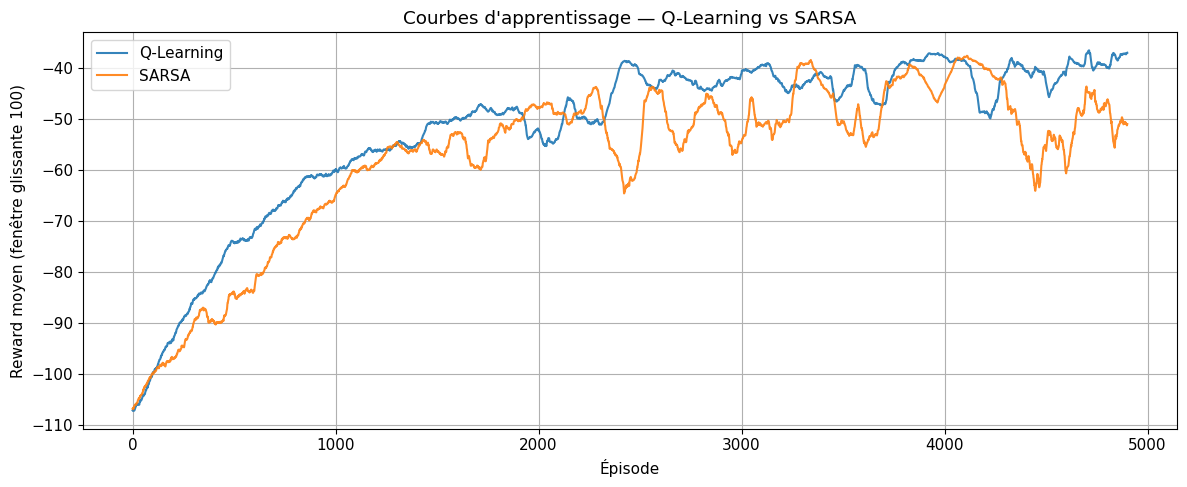

In [6]:
plot_learning_curves({"Q-Learning": rewards_ql, "SARSA": rewards_sarsa})

## 5. DP approchée (Value Iteration backward, horizon fini)

$$V_t(s) = \max_a \Big( \hat{\mathbb{E}}[r(s,a,S')] + \gamma \, \hat{\mathbb{E}}[V_{t+1}(S')] \Big)$$

L'espérance est estimée par $K$ simulations Monte-Carlo depuis le centre de chaque bin. C'est de la **DP approchée** car l'espace continu est discrétisé et les transitions sont estimées empiriquement.

In [17]:
V_dp, pi_dp = run_approximate_dp(config, bin_dicts, K=3, gamma=0.99)
print("DP approchée terminée ✓")


/home/csutty/miniconda3/envs/rlearning/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


États plausibles : 978 / 1331


DP backward:   0%|          | 0/365 [00:00<?, ?it/s]

DP backward:  20%|██        | 73/365 [05:10<18:51,  3.87s/it]

DP backward : t=292 / 365


DP backward:  40%|████      | 146/365 [09:49<14:56,  4.09s/it]

DP backward : t=219 / 365


DP backward:  60%|██████    | 219/365 [14:36<09:12,  3.79s/it]

DP backward : t=146 / 365


DP backward:  80%|████████  | 292/365 [19:20<04:43,  3.88s/it]

DP backward : t=73 / 365


DP backward: 100%|██████████| 365/365 [24:03<00:00,  3.96s/it]

DP backward : t=0 / 365
DP approchée terminée ✓


## 6. Évaluation comparative

On compare les agents RL et DP aux heuristiques de `heuristics.py` :
1. **Aucun contrôle** (laissez-faire)
2. **Vaccination max** (sans confinement)
3. **Seuil confinement** (réactif sur I)
4. **Double seuil adaptatif**

In [25]:
env_eval = SEIREnv(config)
results = {}

# Heuristiques
for name, pol_fn in [
    ("Aucun contrôle", policy_no_control),
    ("Vaccination max", policy_vacc_max),
    ("Seuil confinement", policy_seuil_conf),
    ("Double seuil", policy_double_seuil),
]:
    r, h = record_episode(env_eval, pol_fn)
    results[name] = h
    print(f"{name:25s} → reward total = {r:10.1f}")

# Q-Learning greedy
r, h = record_episode(env_eval, agent_ql.greedy_policy)
results["Q-Learning"] = h
print(f"{'Q-Learning':25s} → reward total = {r:10.1f}")

# SARSA greedy
r, h = record_episode(env_eval, agent_sarsa.greedy_policy)
results["SARSA"] = h
print(f"{'SARSA':25s} → reward total = {r:10.1f}")

# DP approchée (politique time-dependent)
env_dp_eval = SEIREnv(config)

def policy_dp(obs):
    """Politique DP approchée (dépend du step courant)."""
    s = state_to_id(obs, bin_dicts)
    t = min(env_dp_eval.current_step, config.max_steps - 1)
    return actions[pi_dp[t, s]]

r, h = record_episode(env_dp_eval, policy_dp)
results["DP approchée"] = h
print(f"{'DP approchée':25s} → reward total = {r:10.1f}")

Heuristiques définies ✓


## 7. Visualisations

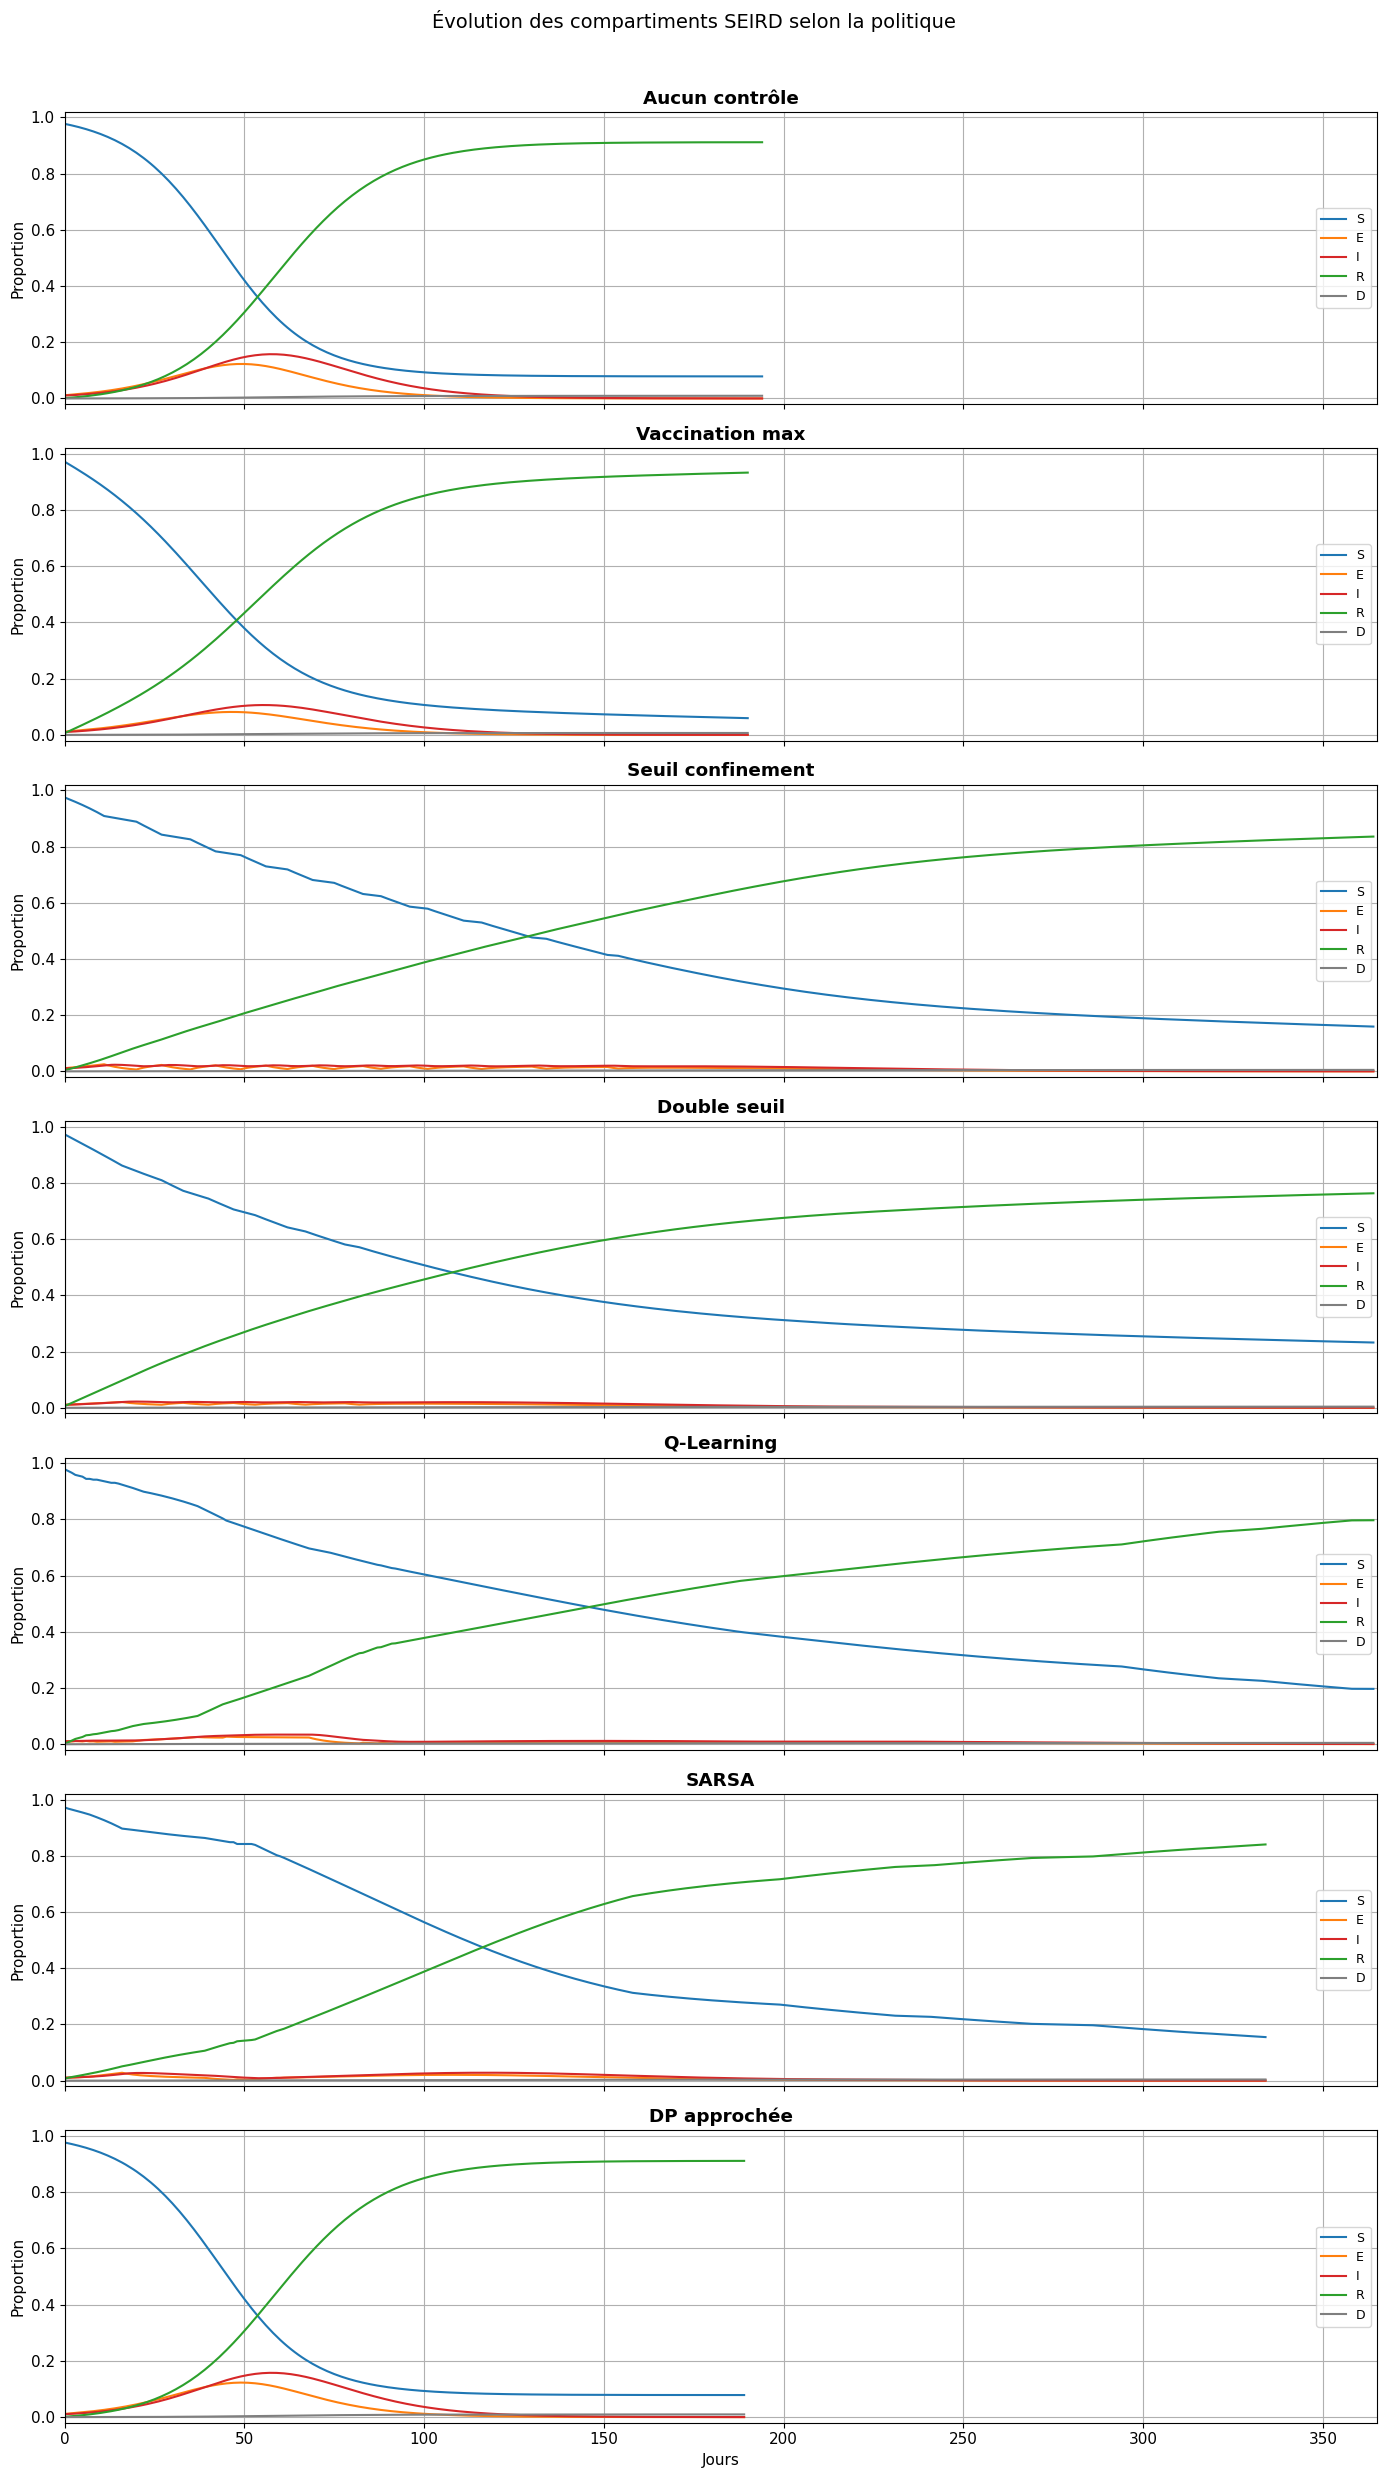

In [55]:
policy_names = list(results.keys())
plot_seird_evolution(results, policy_names)

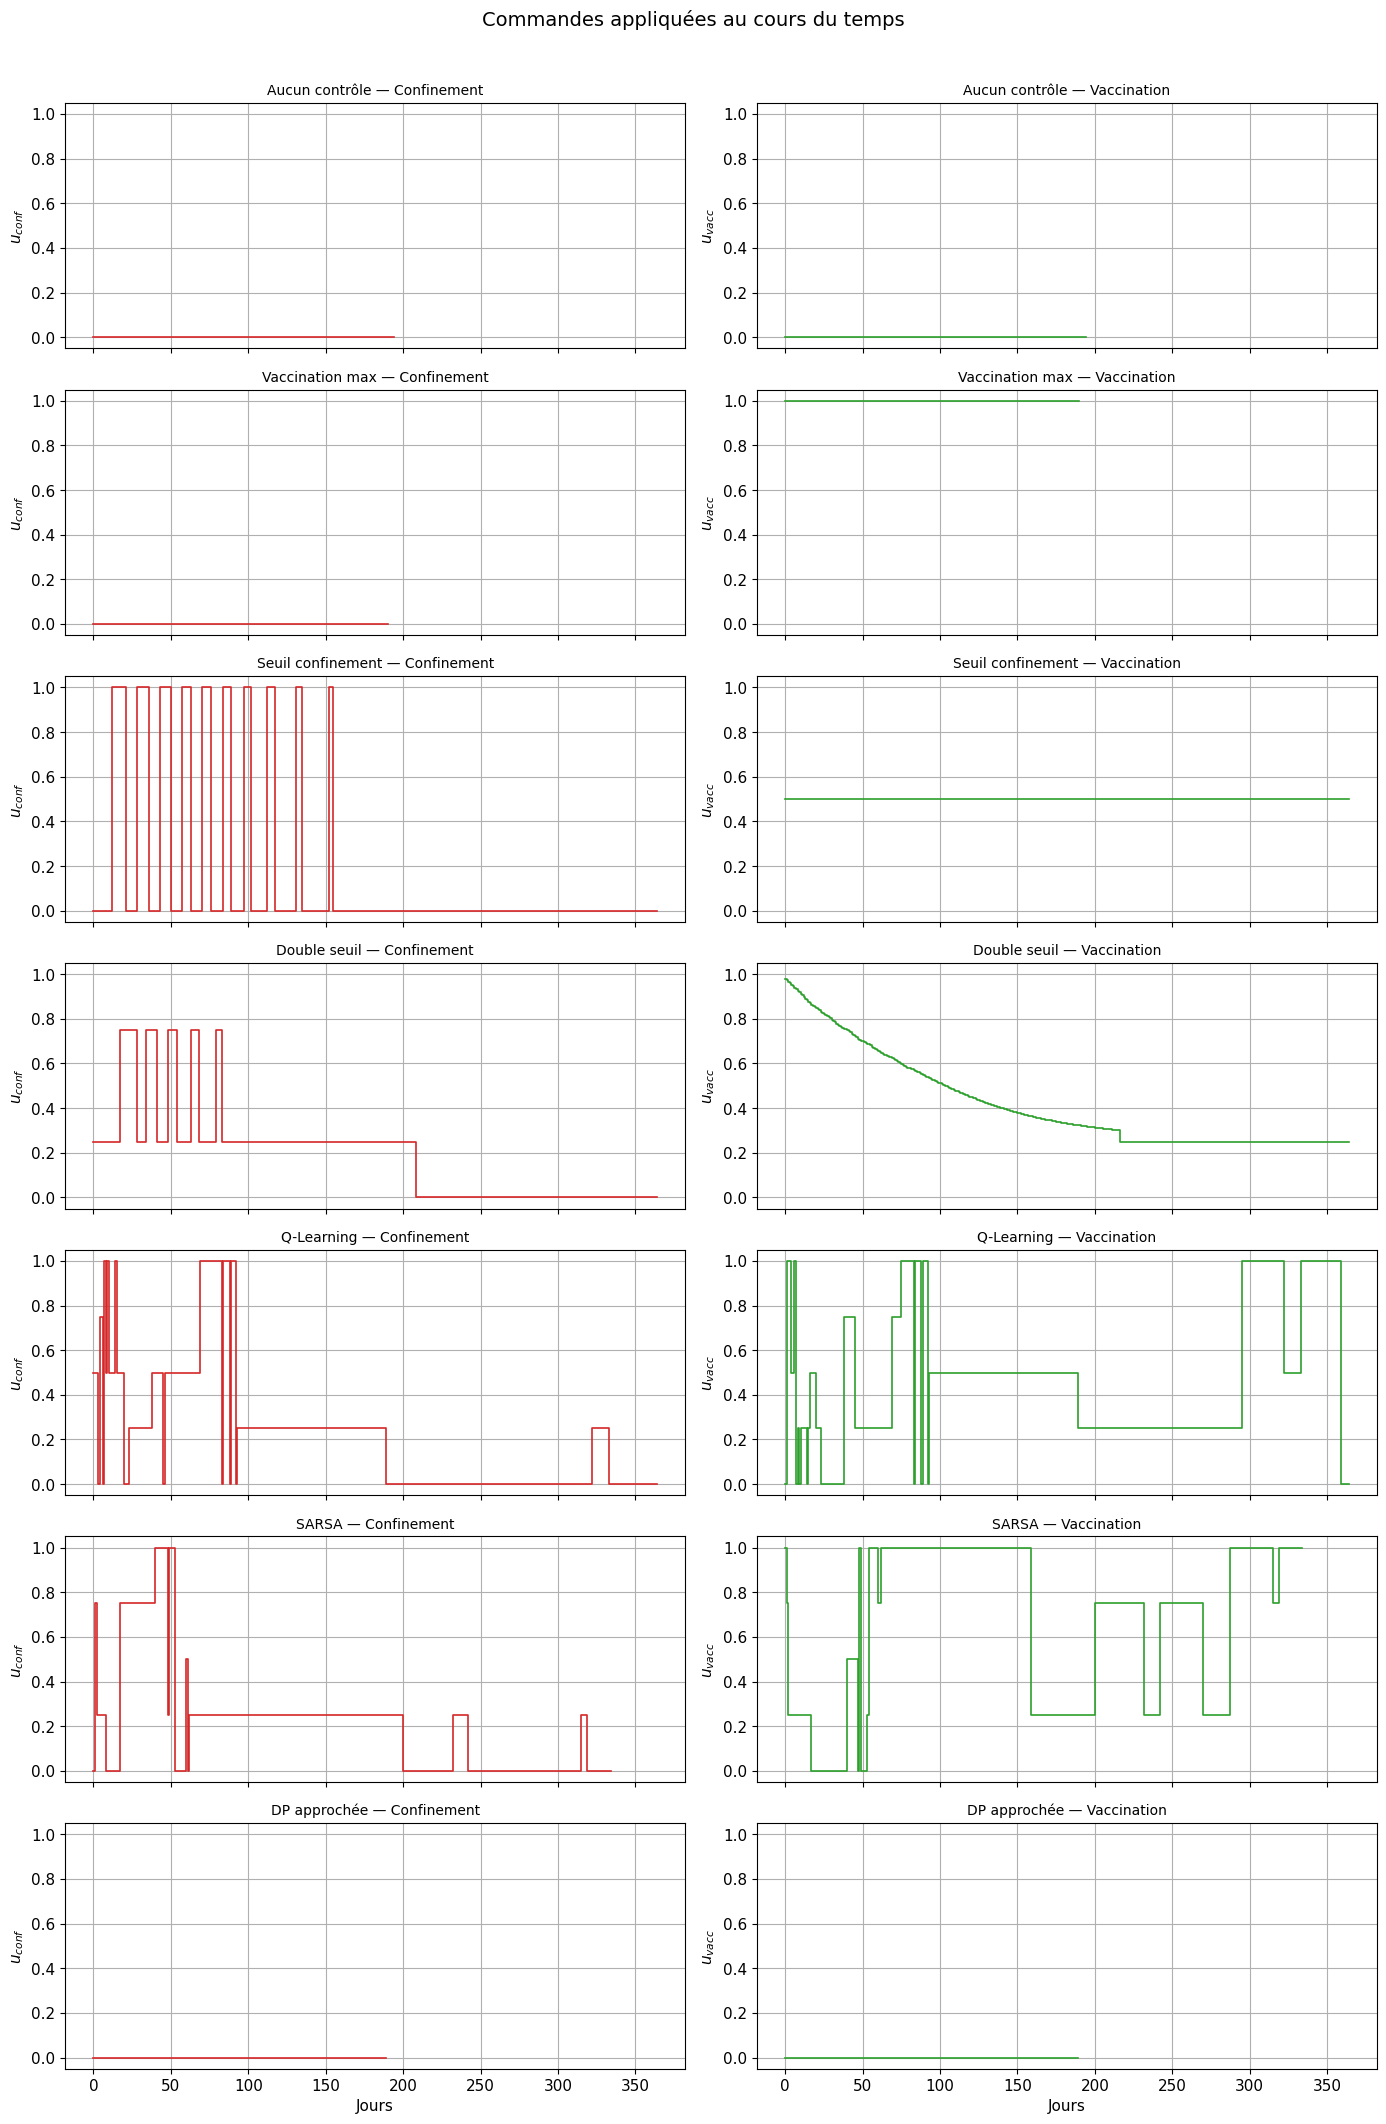

In [ ]:
plot_commands(results, policy_names)

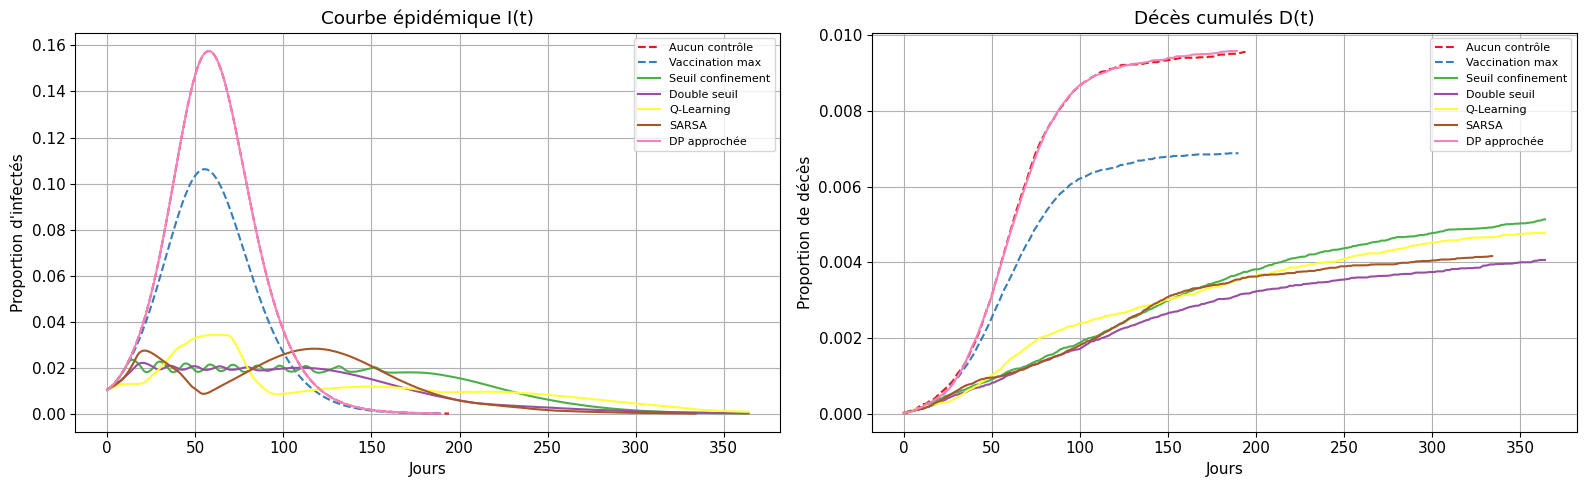

In [ ]:
plot_epidemic_comparison(results, policy_names)

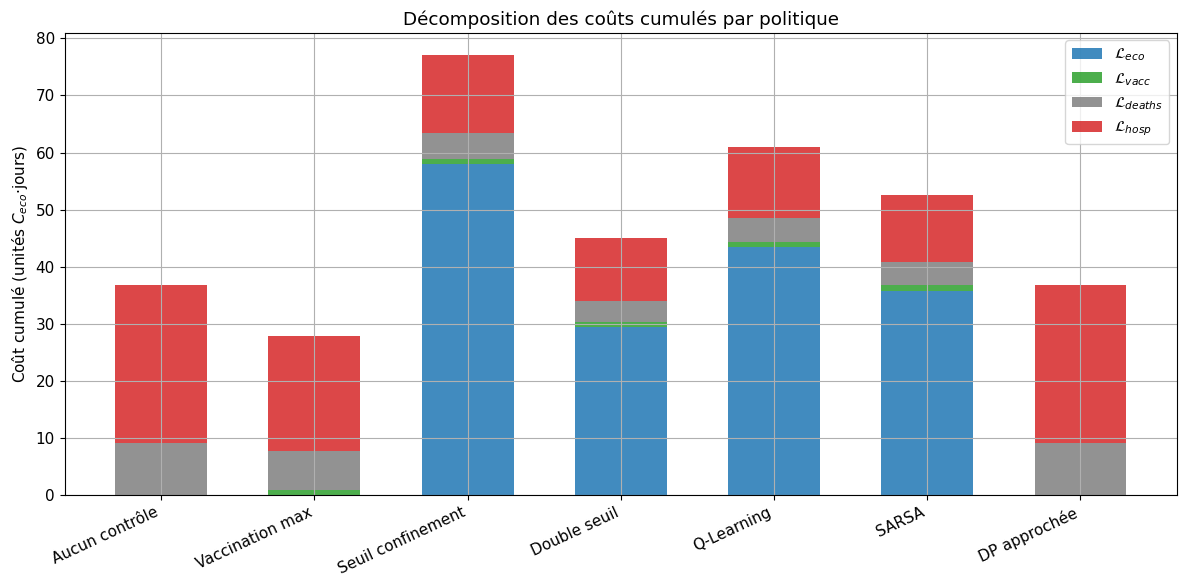


Politique                 |      L_eco |     L_vacc |   L_deaths |     L_hosp |      TOTAL
-------------------------------------------------------------------------------------
Aucun contrôle            |        0.0 |        0.0 |        9.2 |       27.6 |       36.8
Vaccination max           |        0.0 |        1.0 |        6.7 |       20.2 |       27.9
Seuil confinement         |       58.0 |        0.9 |        4.5 |       13.6 |       77.1
Double seuil              |       29.5 |        0.8 |        3.7 |       11.0 |       45.0
Q-Learning                |       43.5 |        0.9 |        4.1 |       12.4 |       61.0
SARSA                     |       35.7 |        1.1 |        4.0 |       11.9 |       52.6
DP approchée              |        0.0 |        0.0 |        9.2 |       27.6 |       36.8


In [30]:
plot_cost_decomposition(results, policy_names)